In [83]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, LSTM, SimpleRNN, Dense, Embedding, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LEE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv('./Data/newsgroup/train.csv')
train.head()

,id,text,target
0,0,"\nThey were, and even if Washington might cons...",10
1,1,"We run ""SpaceNews & Views"" on our STAREACH BBS...",14
2,2,\n\n\nNot to worry. The Masons have been demo...,19
3,3,"Only Brendan McKay, or maybe ARF, would come t...",17
4,4,Help: I am running some sample problems from O...,5


In [4]:
# 결측치 확인
train.isnull().sum()

id        0
text      0
target    0
dtype: int64

In [6]:
X = train.text
y = train.target

y.head()

0    10
1    14
2    19
3    17
4     5
Name: target, dtype: int64

In [9]:
vectorizer = CountVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [10]:
vectorizer.inverse_transform(X)

[array(['and', 'been', 'bust', 'complete', 'consider', 'druce', 'even',
        'goals', 'has', 'here', 'if', 'in', 'might', 'minute', 'only',
        'patty', 'rework', 'that', 'they', 'trade', 'utter', 'washington',
        'were'], dtype='<U81'),
 array(['1500',
        '____________________________________________________________',
        'about', 'access', 'added', 'aerospace', 'ago', 'amount', 'and',
        'are', 'articles', 'bbs', 'being', 'boards', 'but', 'by', 'canada',
        'capability', 'couple', 'currently', 'fair', 'from', 'ftp', 'get',
        'having', 'in', 'internet', 'just', 'link', 'local', 'months',
        'more', 'nasa', 'news', 'of', 'on', 'only', 'operation', 'other',
        'our', 'over', 'periodicals', 'questions', 're', 'related', 'run',
        'running', 'sites', 'software', 'space', 'spacenews', 'stareach',
        'started', 'students', 'sub', 'subscribed', 'system', 'ten', 'the',
        'this', 'through', 'to', 'topics', 'us', 'variety', 'via', '

In [14]:
model_lr = LogisticRegression(max_iter = 500)
model_lr.fit(X, y)

y_pred = model_lr.predict(X[0])
print("예측:", y_pred)
print("실제:", train.target[0])

예측: [10]
실제: 10


In [3]:
test = pd.read_csv('./Data/newsgroup/test.csv')
test.head()

,id,text
0,0,\nThe VL-IDE Adapter can be much faster then t...
1,1,\n\nYeah. In a fire that reportedly burned ho...
2,2,":Judge: ""I grant you immunity from whatever ma..."
3,3,"I, too, put a corbin seat on my Hawk. I got t..."
4,4,\n\nDo I ever!!!!!! After 2 years of having h...


In [17]:
test_X = test.text

test_X_vect = vectorizer.transform(test_X)

pred = model_lr.predict(test_X_vect)
pred

array([ 3, 16, 11, ...,  4,  0,  7], dtype=int64)

In [4]:
submission = pd.read_csv('./Data/newsgroup/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [19]:
submission['target'] = pred
submission.head()

,id,target
0,0,3
1,1,16
2,2,11
3,3,8
4,4,13


In [20]:
submission.to_csv('submission.csv', index = False)

In [27]:
stop_words = stopwords.words('english')
print(len(stop_words))
print(stop_words[:20])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [30]:
tfidf = TfidfVectorizer(ngram_range = (1, 2), stop_words = stop_words)
tfidf.fit(np.array(train['text']))

train_vec = tfidf.transform(train['text'])
train_y = train['target']

test_vec = tfidf.transform(test['text'])

In [31]:
model_mlp = MLPClassifier()
model_mlp.fit(train_vec, train_y)

pred = model_mlp.predict(test_vec)
submission['target'] = pred
submission.head()

C:\Users\LEE\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


,id,target
0,0,3
1,1,16
2,2,11
3,3,8
4,4,7


In [32]:
submission.to_csv("submission2.csv", index = False)

## RNN 계열 모델링

In [42]:
# 전처리
def tokenize_data(train, test, vocab_size, max_len):
    tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
    tokenizer.fit_on_texts(train.text)
    
    for df in [train, test]:
        df["encoded"] = pad_sequences(tokenizer.texts_to_sequences(df.text),
                                     maxlen = max_len,
                                     padding = "post").tolist()

In [43]:
tokenize_data(train, test, 10000, 512)

<AxesSubplot:title={'center':'target distribution'}, ylabel='Frequency'>

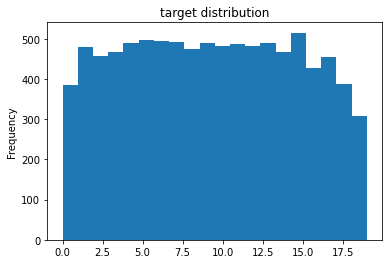

In [24]:
train.target.plot.hist(bins=20, title="target distribution")

In [44]:
EMBEDDING_SIZE = 256
HIDDEN_SIZE = 512
VOCAB_SIZE = 10000
MAXLEN = 512


model = Sequential()
model.add(Embedding(10000, 256))
model.add(LSTM(512))
model.add(Dropout(0.1))
model.add(Dense(20, activation = 'softmax'))

model.compile(optimizer = Adam(1e-2),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
lstm_12 (LSTM)               (None, 512)               1574912   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                10260     
Total params: 4,145,172
Trainable params: 4,145,172
Non-trainable params: 0
_________________________________________________________________


In [49]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)
lr_sche = ReduceLROnPlateau(monitor = 'val_loss', factor = .5)

hist = model.fit(np.array(train.encoded.to_list()),
         np.array(train.target.to_list()),
         epochs = 100,
         batch_size = 256,
         validation_split = .2,
         verbose = 1,
          callbacks = [early_stopping, lr_sche]
         )

Epoch 1/100
29/29 [==============================] - 10s 333ms/step - loss: 2.8275 - acc: 0.1080 - val_loss: 2.9761 - val_acc: 0.0682
Epoch 2/100
29/29 [==============================] - 10s 329ms/step - loss: 2.7498 - acc: 0.1324 - val_loss: 2.8453 - val_acc: 0.0926
Epoch 3/100
29/29 [==============================] - 10s 332ms/step - loss: 2.6621 - acc: 0.1361 - val_loss: 2.7552 - val_acc: 0.1061
Epoch 4/100
29/29 [==============================] - 9s 324ms/step - loss: 2.9084 - acc: 0.1149 - val_loss: 3.4385 - val_acc: 0.0547
Epoch 5/100
29/29 [==============================] - 10s 334ms/step - loss: 3.2626 - acc: 0.0626 - val_loss: 3.1394 - val_acc: 0.0644
Epoch 6/100
29/29 [==============================] - 10s 329ms/step - loss: 3.0088 - acc: 0.1032 - val_loss: 2.9095 - val_acc: 0.1034
Epoch 7/100
29/29 [==============================] - 10s 349ms/step - loss: 2.7885 - acc: 0.1522 - val_loss: 2.7375 - val_acc: 0.1489
Epoch 8/100
29/29 [==============================] - 10s 335ms/

In [ ]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
plt.plot(range(100), hist.history['acc'], 'b--', label = 'Accuracy')
plt.plot(range(100), hist.history['val_acc'], 'r:', label = 'Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(100), hist.history['loss'], 'b--', label = 'Loss')
plt.plot(range(100), hist.history['val_loss'], 'r:', label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.show()

In [62]:
pred = model.predict(np.array(test.encoded.to_list()))
pred

array([[5.29621393e-05, 3.27382330e-03, 1.65787414e-02, ...,
        1.55837421e-04, 2.36069554e-05, 1.02363620e-05],
       [3.79060566e-01, 8.97811027e-04, 1.51702098e-03, ...,
        4.85942587e-02, 5.70419282e-02, 2.15770826e-02],
       [1.01503722e-01, 5.24068309e-05, 5.08643425e-05, ...,
        1.16466016e-01, 2.21797884e-01, 5.64395972e-02],
       ...,
       [5.15135005e-04, 1.44476015e-02, 5.05199842e-02, ...,
        1.33405629e-04, 2.69459924e-05, 6.74976181e-05],
       [1.18003029e-03, 2.08917871e-01, 5.42921901e-01, ...,
        1.04988692e-04, 3.25099041e-04, 1.90039282e-04],
       [3.26739877e-01, 1.63858326e-03, 2.61817873e-03, ...,
        1.59787297e-01, 5.24522774e-02, 6.07702211e-02]], dtype=float32)

In [72]:
test.columns

Index(['id', 'text', 'encoded'], dtype='object')

In [79]:
df_submission_target.flatten()

array([ 3,  0, 11, ...,  4,  2,  0], dtype=int64)

In [80]:
df_submission_target = pred.argmax(axis = -1)
submission = pd.DataFrame({"id":test.id, "target":df_submission_target})
submission.head()

,id,target
0,0,3
1,1,0
2,2,11
3,3,8
4,4,5


In [81]:
submission.to_csv("LSTM_submission.csv", index = False)

In [85]:
model1 = Sequential()

model1.add(Embedding(10000, 256, input_shape = (None, )))
model1.add(GlobalAveragePooling1D())
model1.add(Dense(512, activation = 'relu'))
model1.add(Dropout(0.25))
model1.add(Dense(256, activation = 'relu'))
model1.add(Dropout(0.25))
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.25))
model1.add(Dense(20, activation = 'softmax'))

model1.compile(optimizer = Adam(1e-2),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 256)         2560000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)             

In [86]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)
lr_sche = ReduceLROnPlateau(monitor = 'val_loss', factor = .5)

hist1 = model1.fit(np.array(train.encoded.to_list()),
         np.array(train.target.to_list()),
         epochs = 100,
         batch_size = 256,
         validation_split = .2,
         verbose = 1,
          callbacks = [early_stopping, lr_sche]
         )

Epoch 1/100
29/29 [==============================] - 1s 19ms/step - loss: 2.9145 - acc: 0.0754 - val_loss: 2.6350 - val_acc: 0.1240
Epoch 2/100
29/29 [==============================] - 0s 13ms/step - loss: 2.4953 - acc: 0.1485 - val_loss: 2.4152 - val_acc: 0.1402
Epoch 3/100
29/29 [==============================] - 0s 13ms/step - loss: 2.2081 - acc: 0.2099 - val_loss: 2.0742 - val_acc: 0.2555
Epoch 4/100
29/29 [==============================] - 0s 13ms/step - loss: 1.8224 - acc: 0.3279 - val_loss: 1.9091 - val_acc: 0.3757
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 1.5451 - acc: 0.4452 - val_loss: 1.8611 - val_acc: 0.4158
Epoch 6/100
29/29 [==============================] - 0s 13ms/step - loss: 1.2972 - acc: 0.5468 - val_loss: 2.0368 - val_acc: 0.4169
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 1.2247 - acc: 0.5834 - val_loss: 1.8465 - val_acc: 0.4543
Epoch 8/100
29/29 [==============================] - 0s 13ms/step - loss: 1.

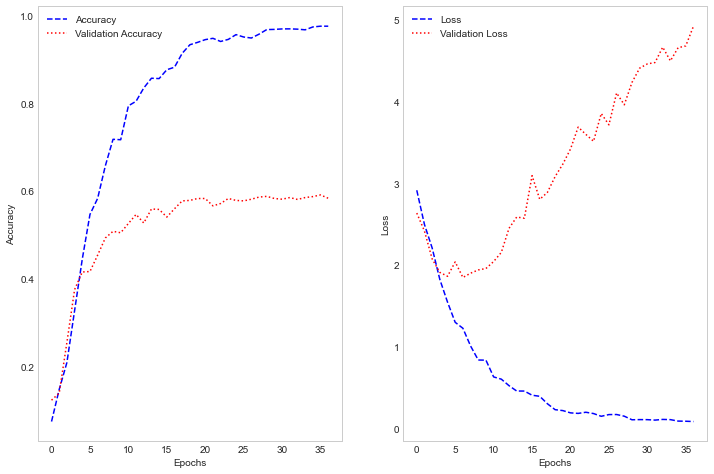

In [88]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
plt.plot(range(37), hist1.history['acc'], 'b--', label = 'Accuracy')
plt.plot(range(37), hist1.history['val_acc'], 'r:', label = 'Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(37), hist1.history['loss'], 'b--', label = 'Loss')
plt.plot(range(37), hist1.history['val_loss'], 'r:', label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.show()

In [89]:
pred = model1.predict(np.array(test.encoded.to_list()))
df_submission_target = pred.argmax(axis = -1)
submission = pd.DataFrame({"id":test.id, "target":df_submission_target})
submission.head()

,id,target
0,0,3
1,1,16
2,2,11
3,3,7
4,4,7


In [90]:
submission.to_csv("Simple_submission.csv", index = False)

In [1]:
!pip3 install -q ktrain

In [10]:
import pandas as pd
import numpy as np

train = pd.read_csv('./Data/newsgroup/train.csv')
test = pd.read_csv('./Data/newsgroup/test.csv')
sample_submission = pd.read_csv('./Data/newsgroup/sample_submission.csv')

train.head()

,id,text,target
0,0,"\nThey were, and even if Washington might cons...",10
1,1,"We run ""SpaceNews & Views"" on our STAREACH BBS...",14
2,2,\n\n\nNot to worry. The Masons have been demo...,19
3,3,"Only Brendan McKay, or maybe ARF, would come t...",17
4,4,Help: I am running some sample problems from O...,5


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train.text, train.target, test_size = .3, random_state = 111)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(6463,) (2770,)
(6463,) (2770,)


In [12]:
TARGET = list(train.target.value_counts().index)
TARGET

[15, 5, 6, 7, 4, 9, 13, 11, 12, 10, 1, 8, 3, 14, 2, 17, 16, 18, 0, 19]

In [37]:
import ktrain
from ktrain import text

MODEL_NAME = "distilbert-base-uncased"

t = text.Transformer(MODEL_NAME, maxlen = 500, classes = TARGET)
trn = t.preprocess_train(np.array(x_train), np.array(y_train))
val = t.preprocess_test(np.array(x_test), np.array(y_test))
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

C:\Users\LEE\anaconda3\lib\site-packages\ktrain\text\preprocessor.py:422: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 191
	95percentile : 585
	99percentile : 1842


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 181
	95percentile : 572
	99percentile : 1861


In [39]:
learner.fit_onecycle(5e-5, 5)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
1078/1078 [==============================] - 372s 344ms/step - loss: 1.0443 - accuracy: 0.7031 - val_loss: 1.0323 - val_accuracy: 0.6917
Epoch 2/5
1078/1078 [==============================] - 374s 346ms/step - loss: 0.7380 - accuracy: 0.7767 - val_loss: 0.9889 - val_accuracy: 0.7047
Epoch 3/5
1078/1078 [==============================] - 363s 336ms/step - loss: 0.5410 - accuracy: 0.8354 - val_loss: 1.0465 - val_accuracy: 0.7126
Epoch 4/5
1078/1078 [==============================] - 355s 328ms/step - loss: 0.2776 - accuracy: 0.9195 - val_loss: 1.0416 - val_accuracy: 0.7321
Epoch 5/5
1078/1078 [==============================] - 409s 379ms/step - loss: 0.1142 - accuracy: 0.9695 - val_loss: 1.0394 - val_accuracy: 0.7455


In [43]:
learner.view_top_losses(n=1, preproc=t)

KeyboardInterrupt: 

In [46]:
predictor = ktrain.get_predictor(learner.model, preproc = t)

res = []

for i in range(9233):
    ss = predictor.predict(test['text'][i])
    res.append(ss)

불용어 제거해서 한번 더 돌려보자
모델링 파트 "maxlen" 수정

In [47]:
sample_submission['target'] = res
sample_submission.head()

,id,target
0,0,7
1,1,16
2,2,8
3,3,12
4,4,4


In [36]:
sample_submission.to_csv("distilbert_submission.csv", index = False)

In [ ]:
p = ktrain.get_predictor(learner.model, preproc = t, batch_size=EVAL_BS)

![ㅇㅇ]("C:/workspace/TIL/데이콘1등.PNG")